<br/>

$$ \huge{\underline{\textbf{ Bandit Parameter Study }}} $$

<br/>

<center>Implementation of <b>Gradient Bandit</b></center>
<center>from Sutton and Barto 2018, <b>chapter 2.10</b>.</center>
<center>Book available for free <a href="http://incompleteideas.net/book/the-book-2nd.html">here</a></center>

<br/>

Parameter study and recreation of figure 2.6.

<br/>

Helper functions

In [1]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == arr.max()))

In [2]:
def softmax(x):
    """Numerically stable softmax"""
    ex = np.exp(x - np.max(x))
    return ex / np.sum(ex)

Bandit algorithms

In [3]:
def simple_bandit(env, nb, eps):
    Q = np.zeros(env.size)
    N = np.zeros(env.size)
    hist_A = []
    hist_R = []
    
    for _ in range(nb):
        A = argmax_rand(Q) if np.random.rand() > eps else np.random.randint(env.size)            
        R = env.step(A)    
        N[A] += 1                
        Q[A] += (1/N[A]) * (R - Q[A])
        
        hist_A.append(A)
        hist_R.append(R)
        
    return Q, np.array(hist_A), np.array(hist_R)

In [4]:
def tracking_bandit(env, nb, eps, alpha, Q_init):
    hist_A = []
    hist_R = []
    
    Q = np.zeros(env.size) + Q_init
    
    for _ in range(nb):
        A = argmax_rand(Q) if np.random.rand() > eps else np.random.randint(env.size)            
        R = env.step(A)    
        Q[A] += alpha * (R - Q[A])
        
        hist_A.append(A)
        hist_R.append(R)
        
    return Q, np.array(hist_A), np.array(hist_R)

In [5]:
def ucb_bandit(env, nb, c):
    Q = np.zeros(env.size)
    N = np.zeros(env.size)
    hist_A = []
    hist_R = []
    
    # select each action at lest once
    for A in range(env.size):
        R = env.step(A)
        N[A] += 1
        Q[A] += (1/N[A]) * (R - Q[A])
        
        hist_A.append(A)
        hist_R.append(R)
    
    for t in range(env.size, nb):
        A = argmax_rand( Q + c * np.sqrt( np.log(t) / N ) )
        R = env.step(A)    
        N[A] += 1                
        Q[A] += (1/N[A]) * (R - Q[A])
        
        hist_A.append(A)
        hist_R.append(R)
        
    return Q, np.array(hist_A), np.array(hist_R)

In [6]:
def gradient_bandit(env, nb, alpha, baseline):
    H = np.zeros(env.size)
    R_, N_ = 0.0, 0.0
    hist_A = []
    hist_R = []
    
    for _ in range(nb):
        pi = softmax(H)
        A = np.random.choice(range(env.size), p=pi)
        R = env.step(A)
        
        H_new = H - alpha*(R-R_)*pi               # for all a =/= A
        H_new[A] = H[A] + alpha*(R-R_)*(1-pi[A])  # for a == A
        H = H_new
        
        if baseline:
            N_ += 1
            R_ += 1/N_ * (R-R_)
        
        hist_A.append(A)
        hist_R.append(R)
        
    return H, np.array(hist_A), np.array(hist_R)

---

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_0206.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure 2.6<center/></td>
    </tr>
</table>

# Experiment Setup

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

Environment

In [8]:
class BanditEnv:
    def __init__(self):
        """10-armed testbed, see chapter 2.3"""
        self.size = 10                                        # 10 arms
        self.offset = 0
        self.means = np.random.normal(loc=self.offset, scale=1.0, size=self.size)
    def step(self, action):
        return np.random.normal(loc=self.means[action])

# Recreate Figure 2.6

Generate data

In [9]:
def run_single_experiment(algorithm, param):
    np.random.seed()  # required due to multiprocessing
    env = BanditEnv()
    if algorithm == 'egreedy_bandit':
        _, _, hist_R = simple_bandit(env, nb=1000, eps=param)
    elif algorithm == 'greedy_opt_bandit':
        _, _, hist_R = tracking_bandit(env, nb=1000, eps=0.0, alpha=0.1, Q_init=param)
    elif algorithm == 'ucb_bandit':
        _, _, hist_R = ucb_bandit(env, nb=1000, c=param)
    elif algorithm == 'gradient_bandit':
        _, _, hist_R = gradient_bandit(env, nb=1000, alpha=param, baseline=True)
    else:
        raise ValueError('Unknown algorithm:', algorithm)
    return hist_R.mean()  # average over 1000 steps

In [10]:
def run_multiple_exp(repeat, algorithm, param):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        param_list = [(algorithm, param)] * repeat
        results = pool.starmap(run_single_experiment, param_list)
        return np.mean(results)

In [11]:
repeat = 2000

In [12]:
egreedy_x, egreedy_y = [], []
for param in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4]:
    result = run_multiple_exp(repeat=repeat, algorithm='egreedy_bandit', param=param)
    print(f'Running e-greedy, eps={param:.3f}: {result:.3f}')
    egreedy_x.append(param)
    egreedy_y.append(result)

Running e-greedy, eps=0.008: 1.160
Running e-greedy, eps=0.016: 1.253
Running e-greedy, eps=0.031: 1.313
Running e-greedy, eps=0.062: 1.333
Running e-greedy, eps=0.125: 1.274
Running e-greedy, eps=0.250: 1.135


In [13]:
greedy_opt_x, greedy_opt_y = [], []
for param in [1/4, 1/2, 1, 2, 4]:
    result = run_multiple_exp(repeat=2000, algorithm='greedy_opt_bandit', param=param)
    print(f'Running greedy with optimistic init., Q_init={param:.3f}: {result:.3f}')
    greedy_opt_x.append(param)
    greedy_opt_y.append(result)

Running greedy with optimistic init., Q_init=0.250: 1.335
Running greedy with optimistic init., Q_init=0.500: 1.391
Running greedy with optimistic init., Q_init=1.000: 1.438
Running greedy with optimistic init., Q_init=2.000: 1.413
Running greedy with optimistic init., Q_init=4.000: 1.315


In [14]:
ucb_x, ucb_y = [], []
for param in [1/16, 1/8, 1/4, 1/2, 1, 2, 4]:
    result = run_multiple_exp(repeat=2000, algorithm='ucb_bandit', param=param)
    print(f'Running UCB, c={param:.3f}: {result:.3f}')
    ucb_x.append(param)
    ucb_y.append(result)

Running UCB, c=0.062: 1.422
Running UCB, c=0.125: 1.422
Running UCB, c=0.250: 1.448
Running UCB, c=0.500: 1.480
Running UCB, c=1.000: 1.478
Running UCB, c=2.000: 1.400
Running UCB, c=4.000: 1.141


In [15]:
gradient_x, gradient_y = [], []
for param in [1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]:
    result = run_multiple_exp(repeat=2000, algorithm='gradient_bandit', param=param)
    print(f'Running gradient, alpha={param:.3f}: {result:.3f}')
    gradient_x.append(param)
    gradient_y.append(result)

Running gradient, alpha=0.031: 1.102
Running gradient, alpha=0.062: 1.260
Running gradient, alpha=0.125: 1.389
Running gradient, alpha=0.250: 1.406
Running gradient, alpha=0.500: 1.393
Running gradient, alpha=1.000: 1.225
Running gradient, alpha=2.000: 1.055
Running gradient, alpha=4.000: 0.837


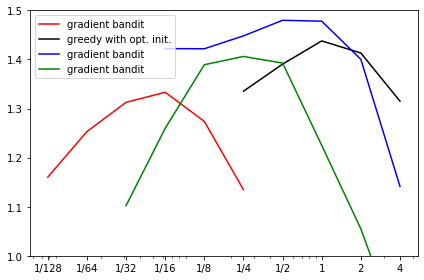

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(egreedy_x, egreedy_y, color='red', label='gradient bandit')
ax.plot(greedy_opt_x, greedy_opt_y, color='black', label='greedy with opt. init.')
ax.plot(ucb_x, ucb_y, color='blue', label='gradient bandit')
ax.plot(gradient_x, gradient_y, color='green', label='gradient bandit')
ax.set_xscale('log')
ax.set_xticks([1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4])
ax.set_xticklabels(['1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4'])
ax.set_ylim((1.0, 1.5))
ax.legend()
plt.tight_layout()
plt.savefig('assets/fig_0206.png')
plt.show()